In [1]:
import pandas as pd

In [2]:
slurm_file_path ="/mnt/sdc/xiaoyu/split_slurm_table.parquet"

In [3]:
slurm_data = pd.read_parquet(slurm_file_path)

In [9]:
slurm_data

,id,start_date,end_date,node,nodetypes,numnodes,numcores,sharednode,submit,start,end,state,exitcode,reservation,partprepaid
0,1,2021-12-26 22:06:31,2021-12-31 22:06:50,r13n5,normal(1),1,16,0,1640538678,1640559991,1640992010,TIMEOUT,0:0,,0
1,2,2021-12-26 22:06:43,2021-12-31 22:06:50,r14n27,normal(1),1,16,0,1640538678,1640560003,1640992010,TIMEOUT,0:0,,0
2,3,2021-12-26 22:06:43,2021-12-31 22:06:50,r15n12,normal(1),1,16,0,1640538678,1640560003,1640992010,TIMEOUT,0:0,,0
3,4,2021-12-26 22:06:43,2021-12-31 22:06:50,r10n14,normal(1),1,16,0,1640538678,1640560003,1640992010,TIMEOUT,0:0,,0
4,5,2021-12-26 22:06:43,2021-12-31 22:06:50,r10n30,normal(1),1,16,0,1640538678,1640560003,1640992010,TIMEOUT,0:0,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596960,2323557,2022-11-01 12:58:19,2022-11-01 12:59:01,r14n20,normal(1),1,16,0,1667310861,1667311099,1667311141,COMPLETED,0:0,,0
1596961,2323558,2022-11-01 12:58:19,2022-11-01 12:59:18,r14n21,normal(1),1,16,0,1667310866,1667311099,1667311158,COMPLETED,0:0,,0
1596962,2323559,2022-11-01 12:55:57,2022-11-01 12:58:54,r28n1,gpu_titanrtx_shared(1),1,6,1,1667310957,1667310957,1667311134,CANCELLED by 53371,0:0,,0
1596963,2323560,2022-11-01 12:56:17,2022-11-01 12:56:24,r13n10,shared(1),1,6,1,1667310972,1667310977,1667310984,FAILED,1:0,,0


In [4]:
slurm_data['state'] = slurm_data['state'].replace({'CANCELLED by .*': 'CANCELLED'}, regex=True)

In [5]:
import re

def parse_rn_string(rn_string):
    pattern = r"([a-z]\d+n)\[(.*?)\]"
    matches = re.findall(pattern, rn_string)

    out_list = []
    for match in matches:
        rn, values = match
        if "," in values:
            nums = values.split(",")
            for num in nums:
                if "-" in num:
                    start, end = map(int, num.split("-"))
                    out_list += [f"{rn}{i}" for i in range(start, end+1)]
                else:
                    out_list += [f"{rn}{num}"]
        elif "-" in values:
            start, end = map(int, values.split("-"))
            out_list += [f"{rn}{i}" for i in range(start, end+1)]
        else:
            out_list += [f"{rn}{values}"]


    pattern_no_brackets = r"([a-z]\d+n\d+)"
    matches_no_brackets = re.findall(pattern_no_brackets, rn_string)
    out_list += matches_no_brackets

    return out_list


                 id
count  1.596965e+06
mean   1.151847e+06
std    6.731614e+05
min    1.000000e+00
25%    5.691700e+05
50%    1.133246e+06
75%    1.741887e+06
max    2.323561e+06


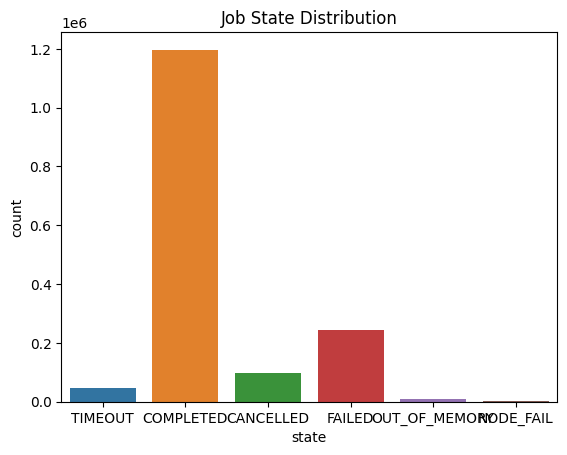

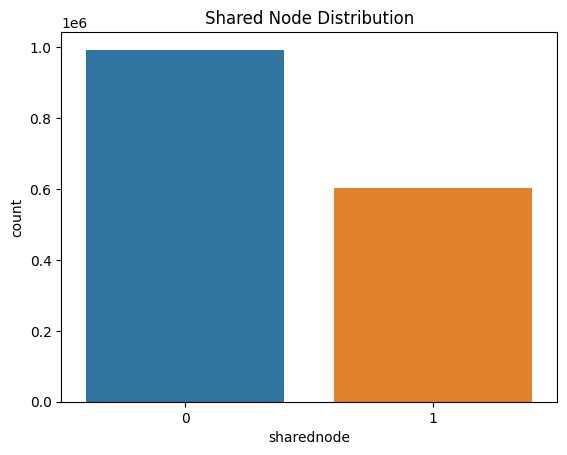

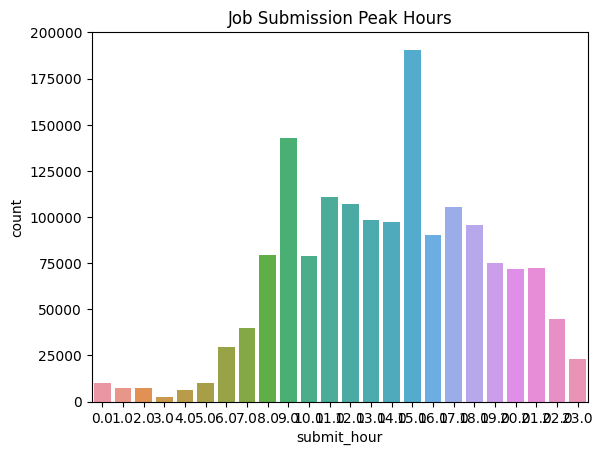

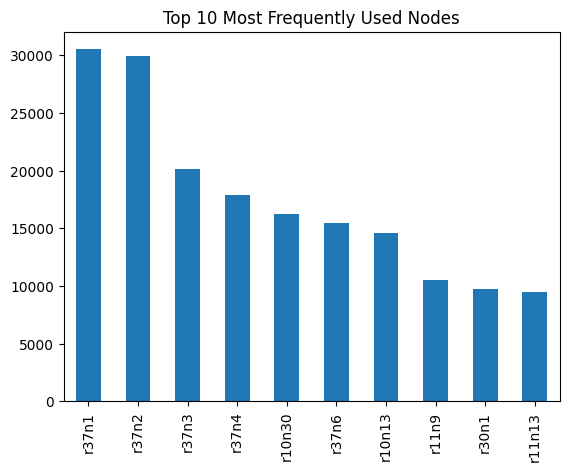

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re





slurm_data['submit'] = pd.to_datetime(slurm_data['submit'], unit='s')
slurm_data['start'] = pd.to_datetime(slurm_data['start'], unit='s')
slurm_data['end'] = pd.to_datetime(slurm_data['end'], unit='s')

slurm_data['parsed_nodes'] = slurm_data['node'].apply(parse_rn_string)

print(slurm_data.describe())

sns.countplot(data=slurm_data, x='state')
plt.title("Job State Distribution")
plt.show()

sns.countplot(data=slurm_data, x='sharednode')
plt.title("Shared Node Distribution")
plt.show()

slurm_data['submit_hour'] = slurm_data['submit'].dt.hour
sns.countplot(data=slurm_data, x='submit_hour')
plt.title("Job Submission Peak Hours")
plt.show()

all_nodes = [node for sublist in slurm_data['parsed_nodes'] for node in sublist]
node_series = pd.Series(all_nodes)
node_counts = node_series.value_counts()
node_counts.head(10).plot(kind='bar')  
plt.title("Top 10 Most Frequently Used Nodes")
plt.show()



In [7]:
total_jobs = len(slurm_data)
print(f"总任务数量: {total_jobs}")

daily_jobs = slurm_data.groupby(slurm_data['submit'].dt.date).size()
print(f"平均每天任务数量: {daily_jobs.mean():.2f}")
print(f"任务数量最多的日期: {daily_jobs.idxmax()}，任务数量: {daily_jobs.max()}")
print(f"任务数量最少的日期: {daily_jobs.idxmin()}，任务数量: {daily_jobs.min()}")

print("\n最频繁使用的10个节点:")
print(node_counts.head(10))

总任务数量: 1596965
平均每天任务数量: 5134.93
任务数量最多的日期: 2022-06-14，任务数量: 162004
任务数量最少的日期: 2021-12-25，任务数量: 2

最频繁使用的10个节点:
r37n1     30502
r37n2     29945
r37n3     20130
r37n4     17917
r10n30    16221
r37n6     15425
r10n13    14572
r11n9     10552
r30n1      9768
r11n13     9485
dtype: int64


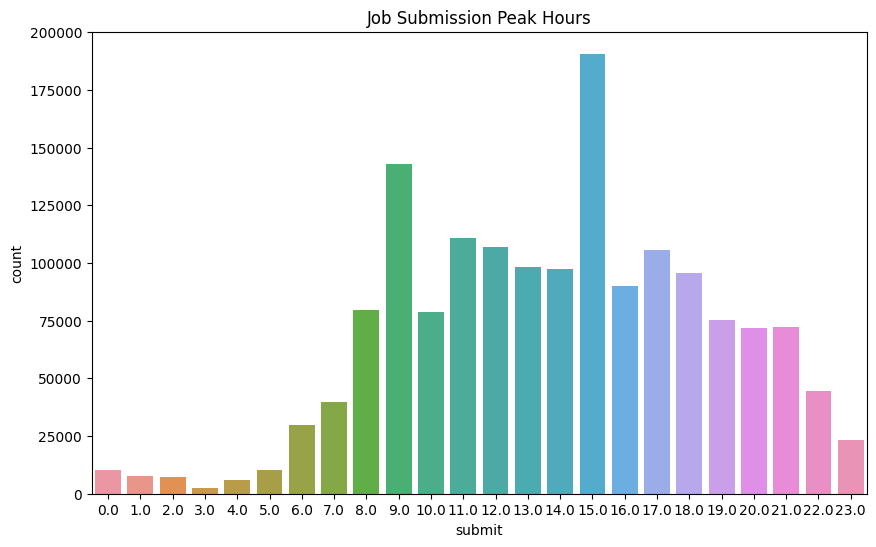

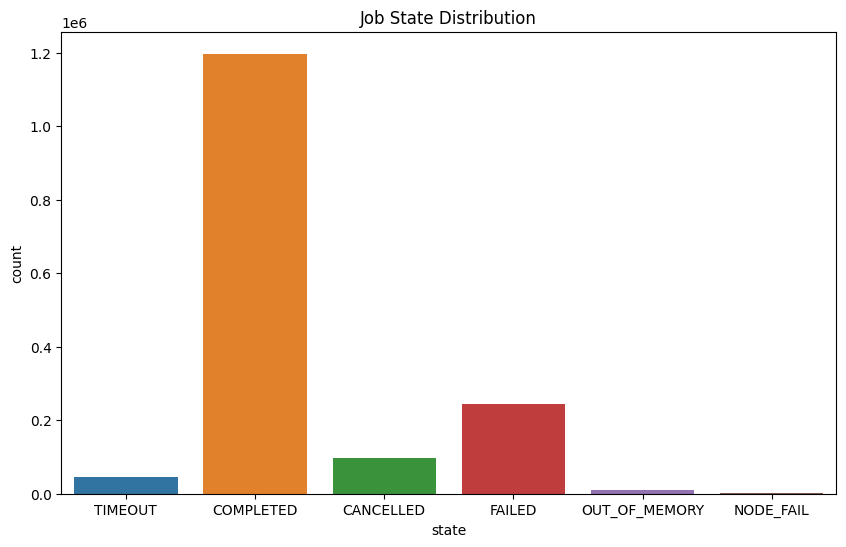

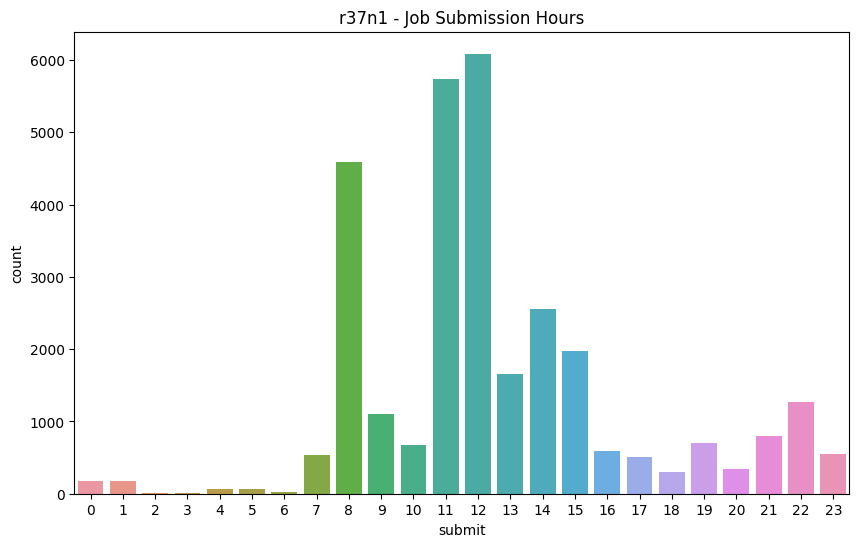

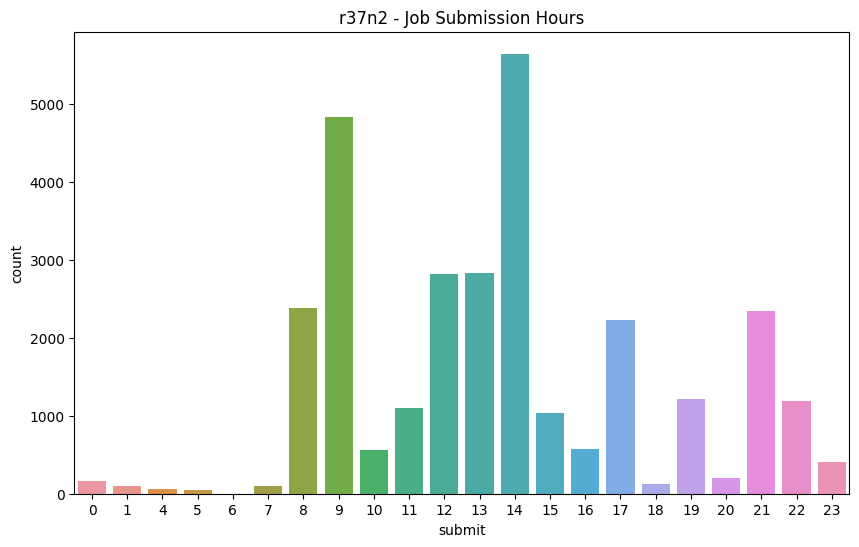

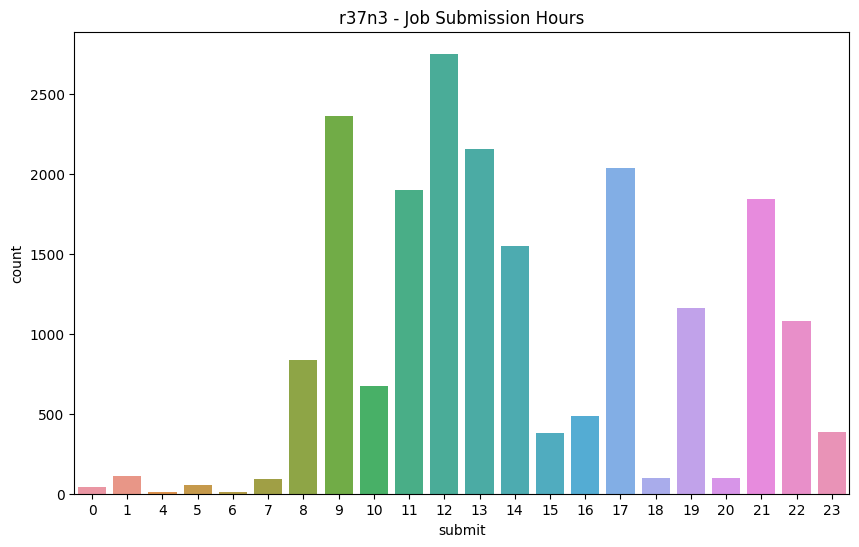

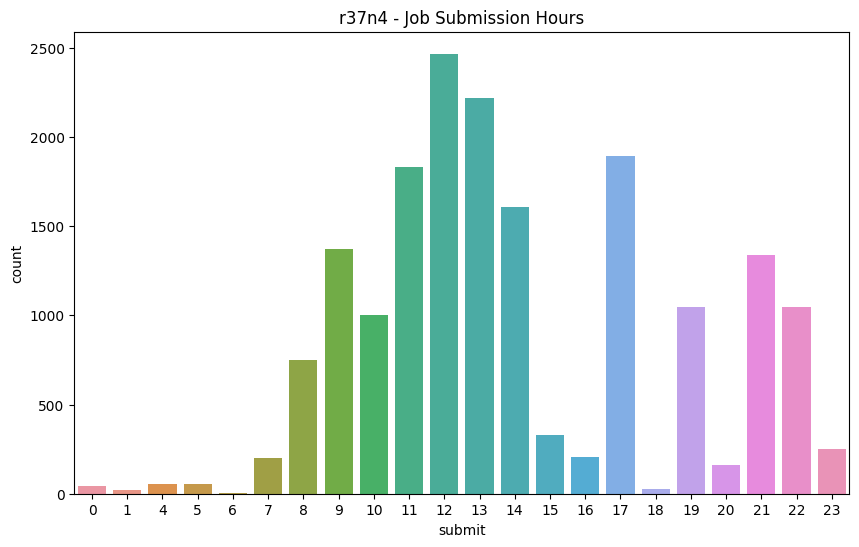

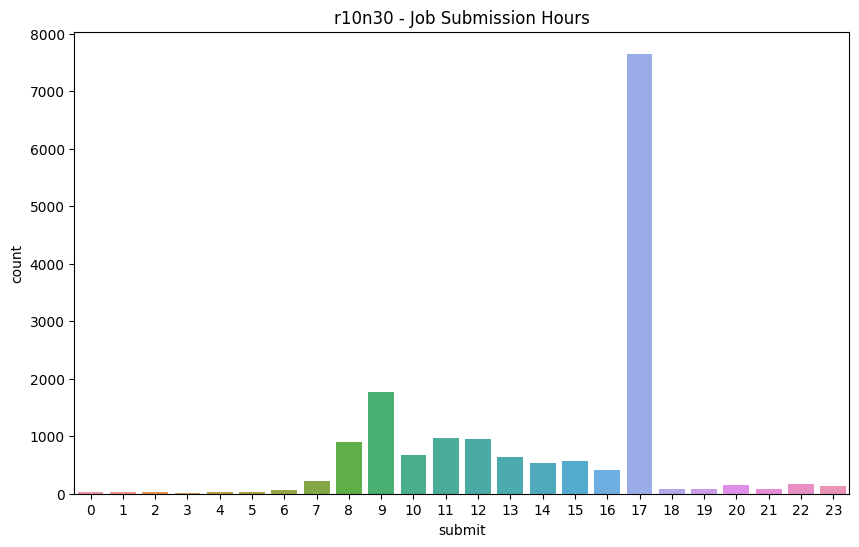

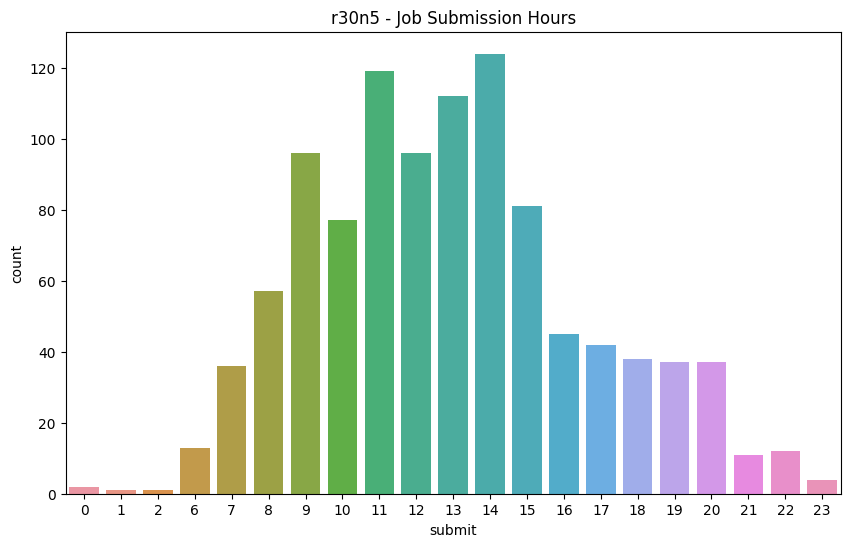

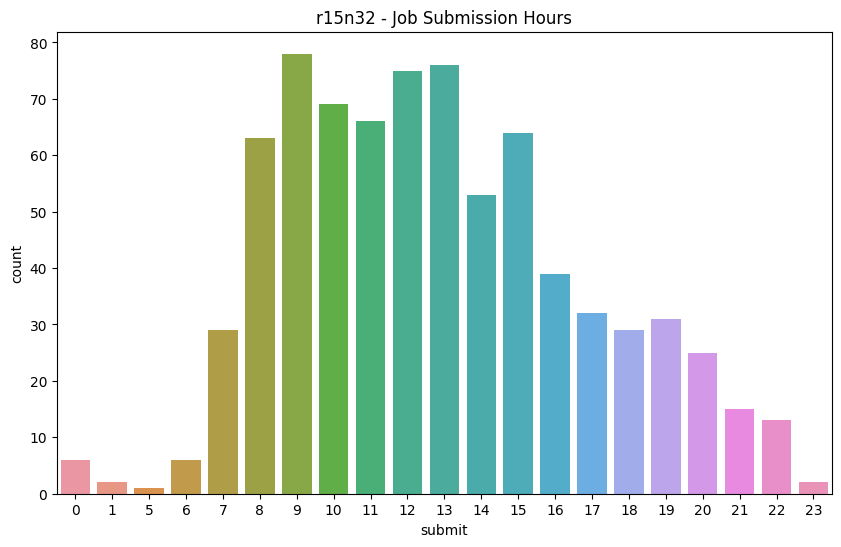

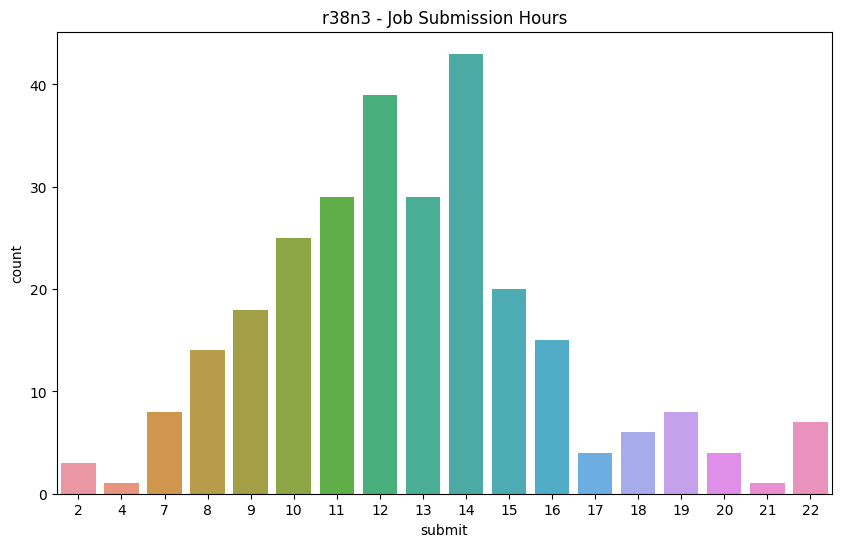

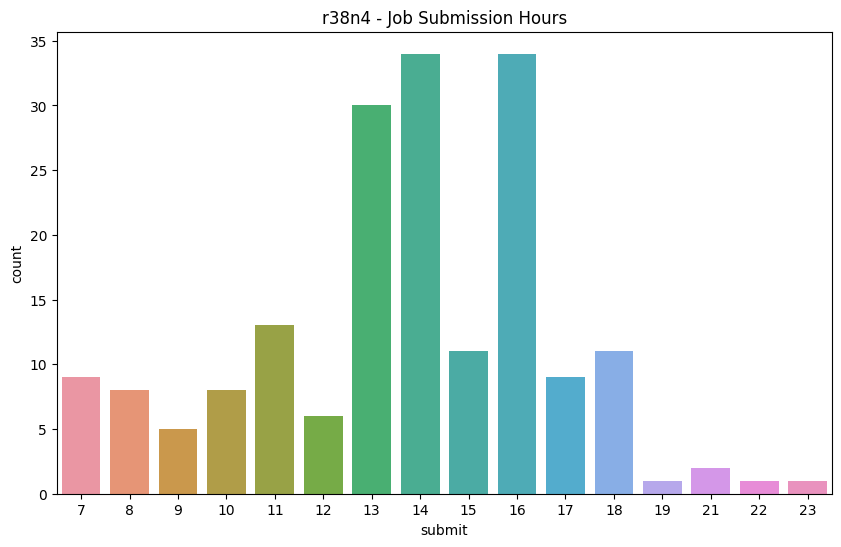

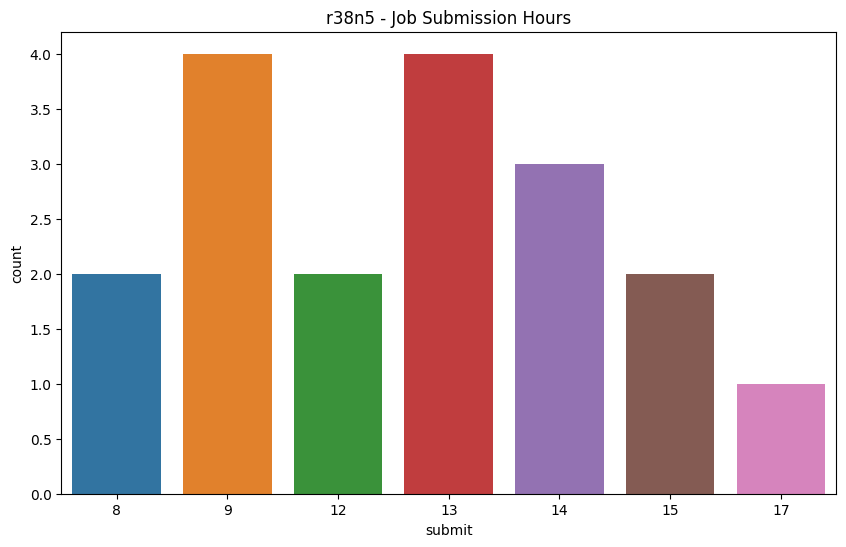

成功率 of r37n1: 85.02%
成功率 of r37n2: 93.26%
成功率 of r37n3: 91.74%
成功率 of r37n4: 92.02%
成功率 of r10n30: 38.62%
成功率 of r30n5: 3.55%
成功率 of r15n32: 2.07%
成功率 of r38n3: 48.91%
成功率 of r38n4: 74.86%
成功率 of r38n5: 33.33%


In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=slurm_data, x=slurm_data['submit'].dt.hour)
plt.title("Job Submission Peak Hours")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=slurm_data, x='state')
plt.title("Job State Distribution")
plt.show()

top_5_nodes = node_counts.head(5).index.tolist()
bottom_5_nodes = node_counts.tail(5).index.tolist()

filtered_nodes = top_5_nodes + bottom_5_nodes
for node in filtered_nodes:
    node_jobs = slurm_data[slurm_data['parsed_nodes'].apply(lambda x: node in x)]
    plt.figure(figsize=(10, 6))
    sns.countplot(data=node_jobs, x=node_jobs['submit'].dt.hour)
    plt.title(f"{node} - Job Submission Hours")
    plt.show()

for node in filtered_nodes:
    node_jobs = slurm_data[slurm_data['parsed_nodes'].apply(lambda x: node in x)]
    success_rate = (node_jobs['state'] == "COMPLETED").mean()
    print(f"成功率 of {node}: {success_rate*100:.2f}%")




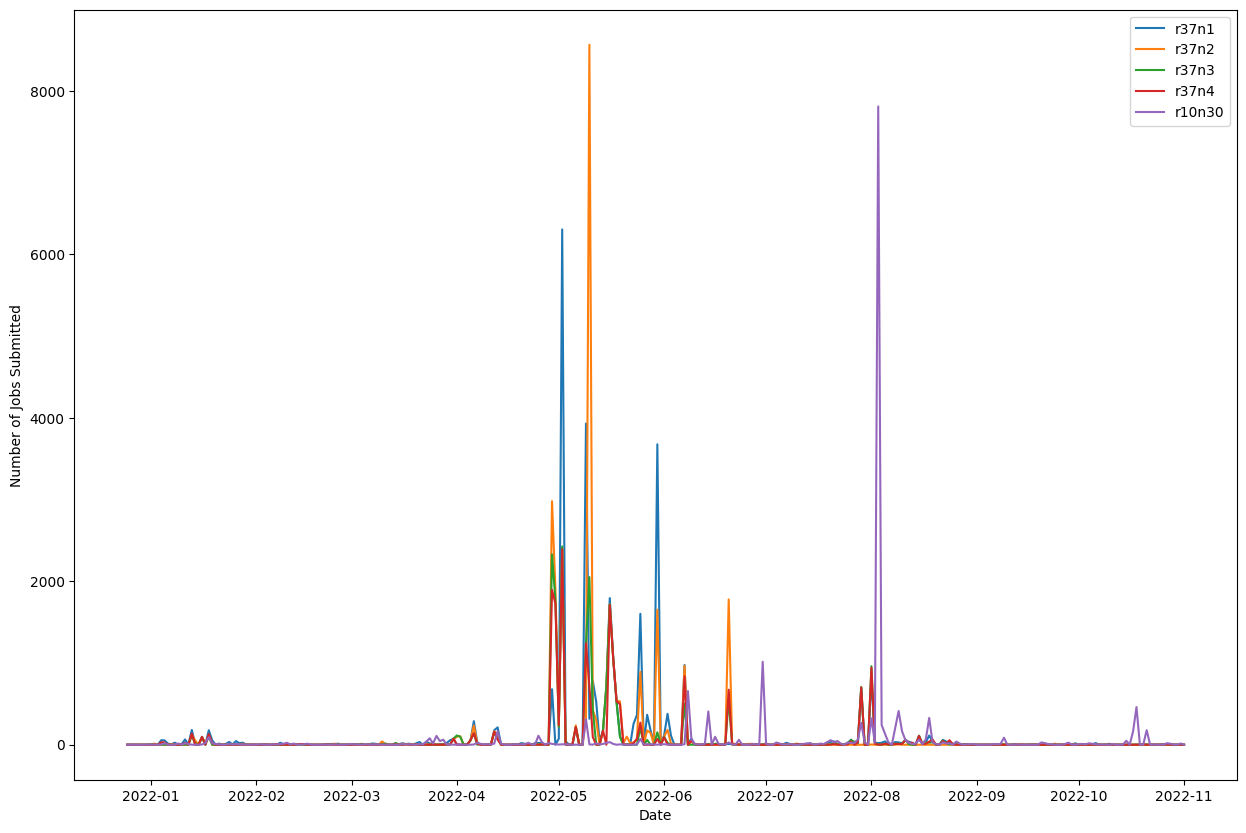

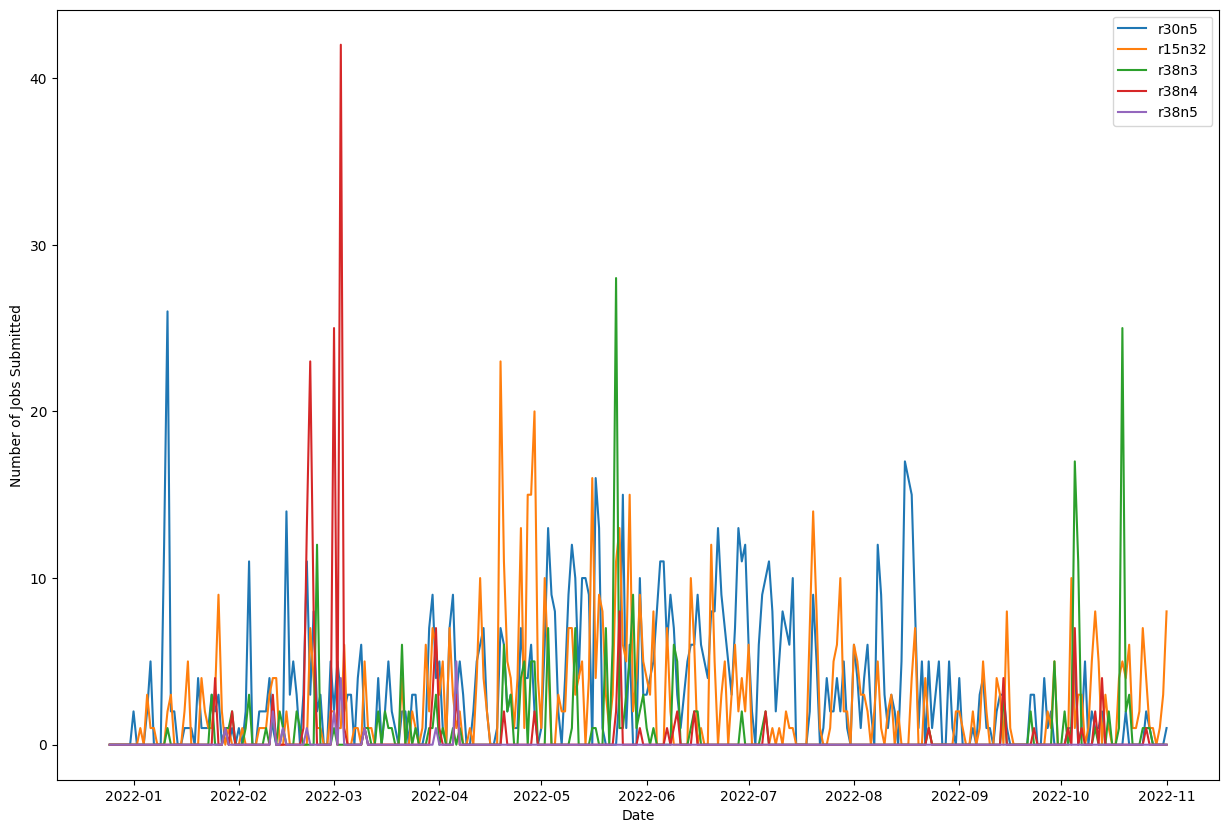

Success rate for r37n1: 0.00%
Success rate for r37n2: 0.00%
Success rate for r37n3: 0.00%
Success rate for r37n4: 0.00%
Success rate for r10n30: 0.00%
Success rate for r30n5: 0.00%
Success rate for r15n32: 0.00%
Success rate for r38n3: 0.00%
Success rate for r38n4: 0.00%
Success rate for r38n5: 0.00%


In [17]:
date_range = pd.date_range(start=slurm_data['submit'].min().date(), 
                           end=slurm_data['submit'].max().date(), freq='D')

top_5_nodes = node_counts.head(5).index.tolist()
bottom_5_nodes = node_counts.tail(5).index.tolist()

submission_df_top = pd.DataFrame(index=date_range)
submission_df_bottom = pd.DataFrame(index=date_range)

for node in top_5_nodes:
    node_jobs = slurm_data[slurm_data['parsed_nodes'].apply(lambda x: node in x)]
    node_daily_counts = node_jobs.groupby(node_jobs['submit'].dt.date).size()
    submission_df_top[node] = node_daily_counts

submission_df_top.fillna(0, inplace=True)

for node in bottom_5_nodes:
    node_jobs = slurm_data[slurm_data['parsed_nodes'].apply(lambda x: node in x)]
    node_daily_counts = node_jobs.groupby(node_jobs['submit'].dt.date).size()
    submission_df_bottom[node] = node_daily_counts

submission_df_bottom.fillna(0, inplace=True)

plt.figure(figsize=(15, 10))
for node in top_5_nodes:
    plt.plot(submission_df_top[node], label=node)
    

plt.xlabel("Date")
plt.ylabel("Number of Jobs Submitted")
plt.legend()
plt.savefig("top_5_nodes_submission.pdf")  
plt.show()

plt.figure(figsize=(15, 10))
for node in bottom_5_nodes:
    plt.plot(submission_df_bottom[node], label=node)
    

plt.xlabel("Date")
plt.ylabel("Number of Jobs Submitted")
plt.legend()
plt.savefig("bottom_5_nodes_submission.pdf")  
plt.show()

all_nodes = top_5_nodes + bottom_5_nodes
for node in all_nodes:
    node_jobs = slurm_data[slurm_data['parsed_nodes'].apply(lambda x: node in x)]
    success_rate = (node_jobs['state'] == "COMPLETE").mean()
    print(f"Success rate for {node}: {success_rate*100:.2f}%")

Hourly job submissions:
0.0      10336
1.0       7569
2.0       7163
3.0       2574
4.0       6044
5.0      10260
6.0      29718
7.0      39741
8.0      79476
9.0     142712
10.0     78603
11.0    111022
12.0    106845
13.0     98141
14.0     97289
15.0    190682
16.0     90002
17.0    105565
18.0     95689
19.0     75326
20.0     71802
21.0     72412
22.0     44722
23.0     23270
Name: submit, dtype: int64

Hourly submission ratio (%):
0.0      0.65
1.0      0.47
2.0      0.45
3.0      0.16
4.0      0.38
5.0      0.64
6.0      1.86
7.0      2.49
8.0      4.98
9.0      8.94
10.0     4.92
11.0     6.95
12.0     6.69
13.0     6.15
14.0     6.09
15.0    11.94
16.0     5.64
17.0     6.61
18.0     5.99
19.0     4.72
20.0     4.50
21.0     4.53
22.0     2.80
23.0     1.46
Name: submit, dtype: float64

The busiest hour is 15.0 with 190682 submissions.
The quietest hour is 3.0 with 2574 submissions.

Job state distribution:
COMPLETED        1197035
FAILED            245301
CANCELLED          9

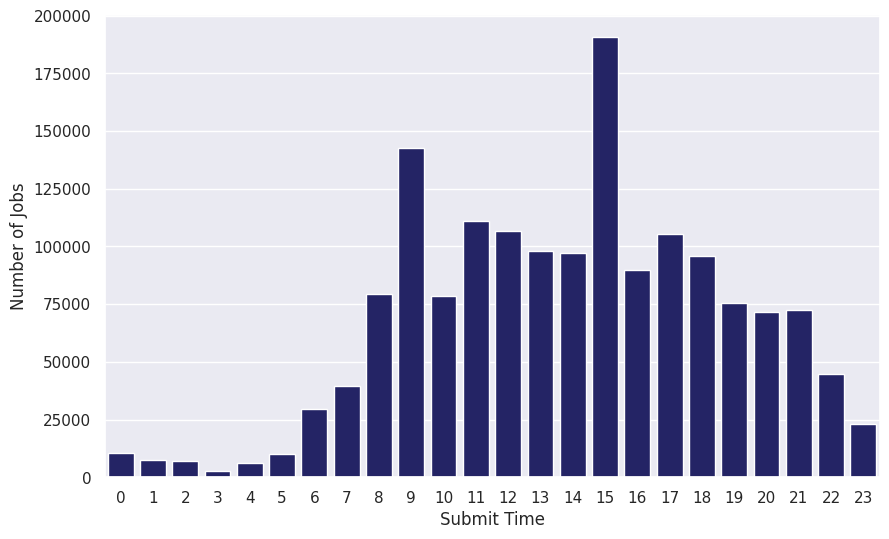

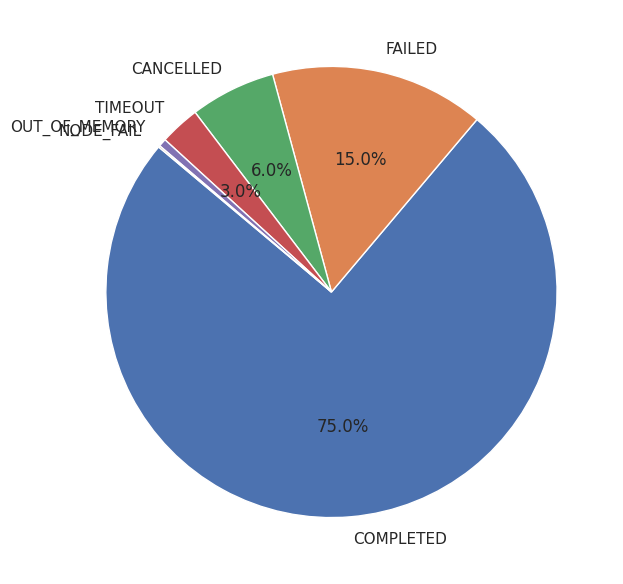

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

hourly_submissions = slurm_data['submit'].dt.hour.value_counts().sort_index()
total_submissions = hourly_submissions.sum()
hourly_submission_ratio = (hourly_submissions / total_submissions) * 100

print("Hourly job submissions:")
print(hourly_submissions)

print("\nHourly submission ratio (%):")
print(hourly_submission_ratio.round(2))

busiest_hour = hourly_submissions.idxmax()
print(f"\nThe busiest hour is {busiest_hour} with {hourly_submissions[busiest_hour]} submissions.")

quietest_hour = hourly_submissions.idxmin()
print(f"The quietest hour is {quietest_hour} with {hourly_submissions[quietest_hour]} submissions.")

plt.figure(figsize=(10, 6))
sns.countplot(data=slurm_data, x=slurm_data['submit'].dt.hour, color='midnightblue')  
plt.xticks(np.arange(0, 24), [str(i) for i in range(24)])
plt.xlabel("Submit Time")
plt.ylabel("Number of Jobs")  
plt.savefig("hourly_submissions_bar_chart.pdf")


state_counts = slurm_data['state'].value_counts()
state_ratio = (state_counts / state_counts.sum()) * 100

print("\nJob state distribution:")
print(state_counts)

print("\nJob state ratio (%):")
print(state_ratio.round(2))

most_common_state = state_counts.idxmax()
print(f"\nThe most common state is {most_common_state} with {state_counts[most_common_state]} occurrences.")
least_common_state = state_counts.idxmin()
print(f"The least common state is {least_common_state} with {state_counts[least_common_state]} occurrences.")

fig, ax = plt.subplots(figsize=(10, 6))
state_counts.plot(kind='pie', autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 2 else '', startangle=140, ax=ax)
ax.set_ylabel('')
plt.tight_layout()
plt.savefig("job_state_distribution_pie_chart.pdf")



Job state distribution:
COMPLETED        1197035
FAILED            245301
CANCELLED          97877
TIMEOUT            45918
OUT_OF_MEMORY       9064
NODE_FAIL           1768
Name: state, dtype: int64

Job state ratio (%):
COMPLETED        74.96
FAILED           15.36
CANCELLED         6.13
TIMEOUT           2.88
OUT_OF_MEMORY     0.57
NODE_FAIL         0.11
Name: state, dtype: float64

The most common state is COMPLETED with 1197035 occurrences.
The least common state is NODE_FAIL with 1768 occurrences.


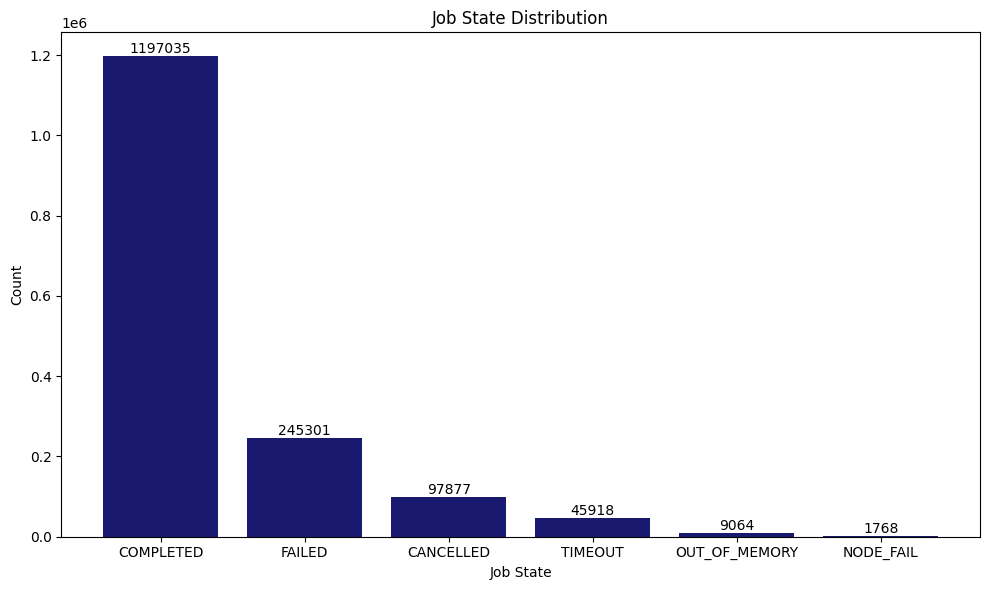

In [13]:
import matplotlib.pyplot as plt

state_counts = slurm_data['state'].value_counts()
state_ratio = (state_counts / state_counts.sum()) * 100

print("\nJob state distribution:")
print(state_counts)

print("\nJob state ratio (%):")
print(state_ratio.round(2))

most_common_state = state_counts.idxmax()
print(f"\nThe most common state is {most_common_state} with {state_counts[most_common_state]} occurrences.")
least_common_state = state_counts.idxmin()
print(f"The least common state is {least_common_state} with {state_counts[least_common_state]} occurrences.")

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(state_counts.index, state_counts.values, color='midnightblue')

ax.set_xlabel('Job State')
ax.set_ylabel('Count')
ax.set_title('Job State Distribution')

for i, v in enumerate(state_counts.values):
    ax.text(i, v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig("job_state_distribution_bar_chart.pdf")
plt.show()


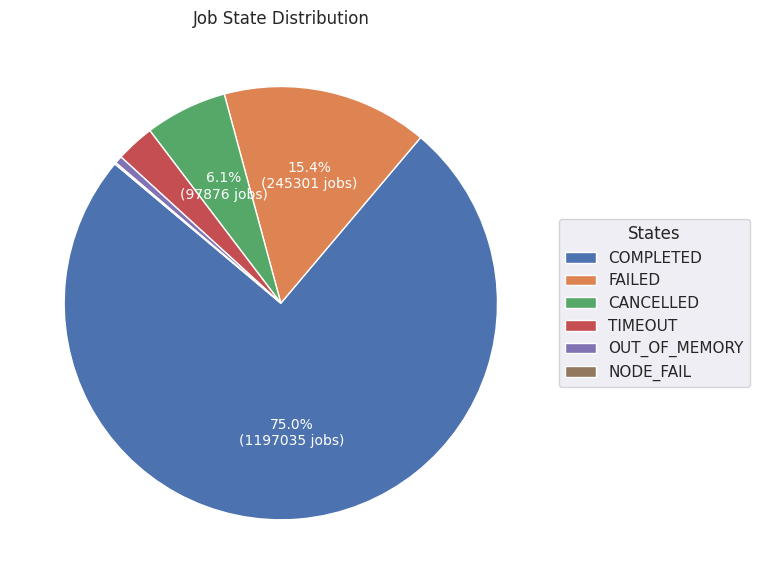

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    if pct < 3: 
        return ""
    else:
        return "{:.1f}%\n({:d} jobs)".format(pct, absolute)

wedges, texts, autotexts = ax.pie(state_counts, 
                                  autopct=lambda pct: func(pct, state_counts),
                                  textprops=dict(color="w"),
                                  startangle=140)

for text, autotext in zip(texts, autotexts):
    text.set(size=10)
    autotext.set(size=10)

ax.legend(wedges, state_counts.index,
          title="States",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Job State Distribution")
plt.tight_layout()
plt.savefig("job_state_distribution_pie_chart.pdf")


In [31]:
summary_data = []

def get_peak_time(node, df):
    """获取节点的波峰时间"""
    node_series = df[node]
    peak_day = node_series.idxmax()  
    return peak_day

for node in top_5_nodes:
    node_data = slurm_data[slurm_data['parsed_nodes'].apply(lambda x: node in x)]
    total_jobs = node_data.shape[0]
    daily_average = submission_df_top[node].mean()
    daily_std = submission_df_top[node].std()
    daily_max = submission_df_top[node].max()
    daily_min = submission_df_top[node].min()
    success_rate = (node_data['state'] == "COMPLETE").mean()
    peak_time = get_peak_time(node, submission_df_top)
    
    summary_data.append({
        'Node': node,
        'Total Jobs': total_jobs,
        'Daily Average': daily_average,
        'Daily Std': daily_std,
        'Daily Max': daily_max,
        'Daily Min': daily_min,
        'Success Rate (%)': success_rate * 100,
        'Peak Time': peak_time
    })

for node in bottom_5_nodes:
    node_data = slurm_data[slurm_data['parsed_nodes'].apply(lambda x: node in x)]
    total_jobs = node_data.shape[0]
    daily_average = submission_df_bottom[node].mean()
    daily_std = submission_df_bottom[node].std()
    daily_max = submission_df_bottom[node].max()
    daily_min = submission_df_bottom[node].min()
    success_rate = (node_data['state'] == "COMPLETE").mean()
    peak_time = get_peak_time(node, submission_df_bottom)
    
    summary_data.append({
        'Node': node,
        'Total Jobs': total_jobs,
        'Daily Average': daily_average,
        'Daily Std': daily_std,
        'Daily Max': daily_max,
        'Daily Min': daily_min,
        'Success Rate (%)': success_rate * 100,
        'Peak Time': peak_time
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)


     Node  Total Jobs  Daily Average   Daily Std  Daily Max  Daily Min  \
0   r37n1       30502      97.762821  500.750197     6305.0        0.0   
1   r37n2       29945      95.977564  573.524851     8565.0        0.0   
2   r37n3       20130      64.519231  290.888670     2426.0        0.0   
3   r37n4       17917      57.426282  258.668644     2390.0        0.0   
4  r10n30       16221      51.990385  449.739206     7810.0        0.0   
5   r30n5        1041       3.336538    3.965958       26.0        0.0   
6  r15n32         774       2.480769    3.561984       23.0        0.0   
7   r38n3         274       0.878205    2.798353       28.0        0.0   
8   r38n4         183       0.586538    3.270084       42.0        0.0   
9   r38n5          18       0.057692    0.412667        5.0        0.0   

   Success Rate (%)  Peak Time  
0               0.0 2022-05-02  
1               0.0 2022-05-10  
2               0.0 2022-05-02  
3               0.0 2022-05-02  
4               0.0 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.pyplot as plt

slurm_data['nodes_list'] = slurm_data['node'].apply(parse_rn_string)

df_list = []
for index, row in slurm_data.iterrows():
    for node in row['nodes_list']:
        df_list.append([node, pd.to_datetime(row['start']).date()])

node_date_df = pd.DataFrame(df_list, columns=['node', 'day'])

agg_df = node_date_df.groupby(['node', 'day']).size().reset_index(name='count')

pivot_df = agg_df.pivot('day', 'node', 'count').fillna(0)












/tmp/ipykernel_613014/1396648315.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = agg_df.pivot('day', 'node', 'count').fillna(0)


/tmp/ipykernel_609740/3643316224.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = agg_df.pivot('node', 'day', 'count').fillna(0)


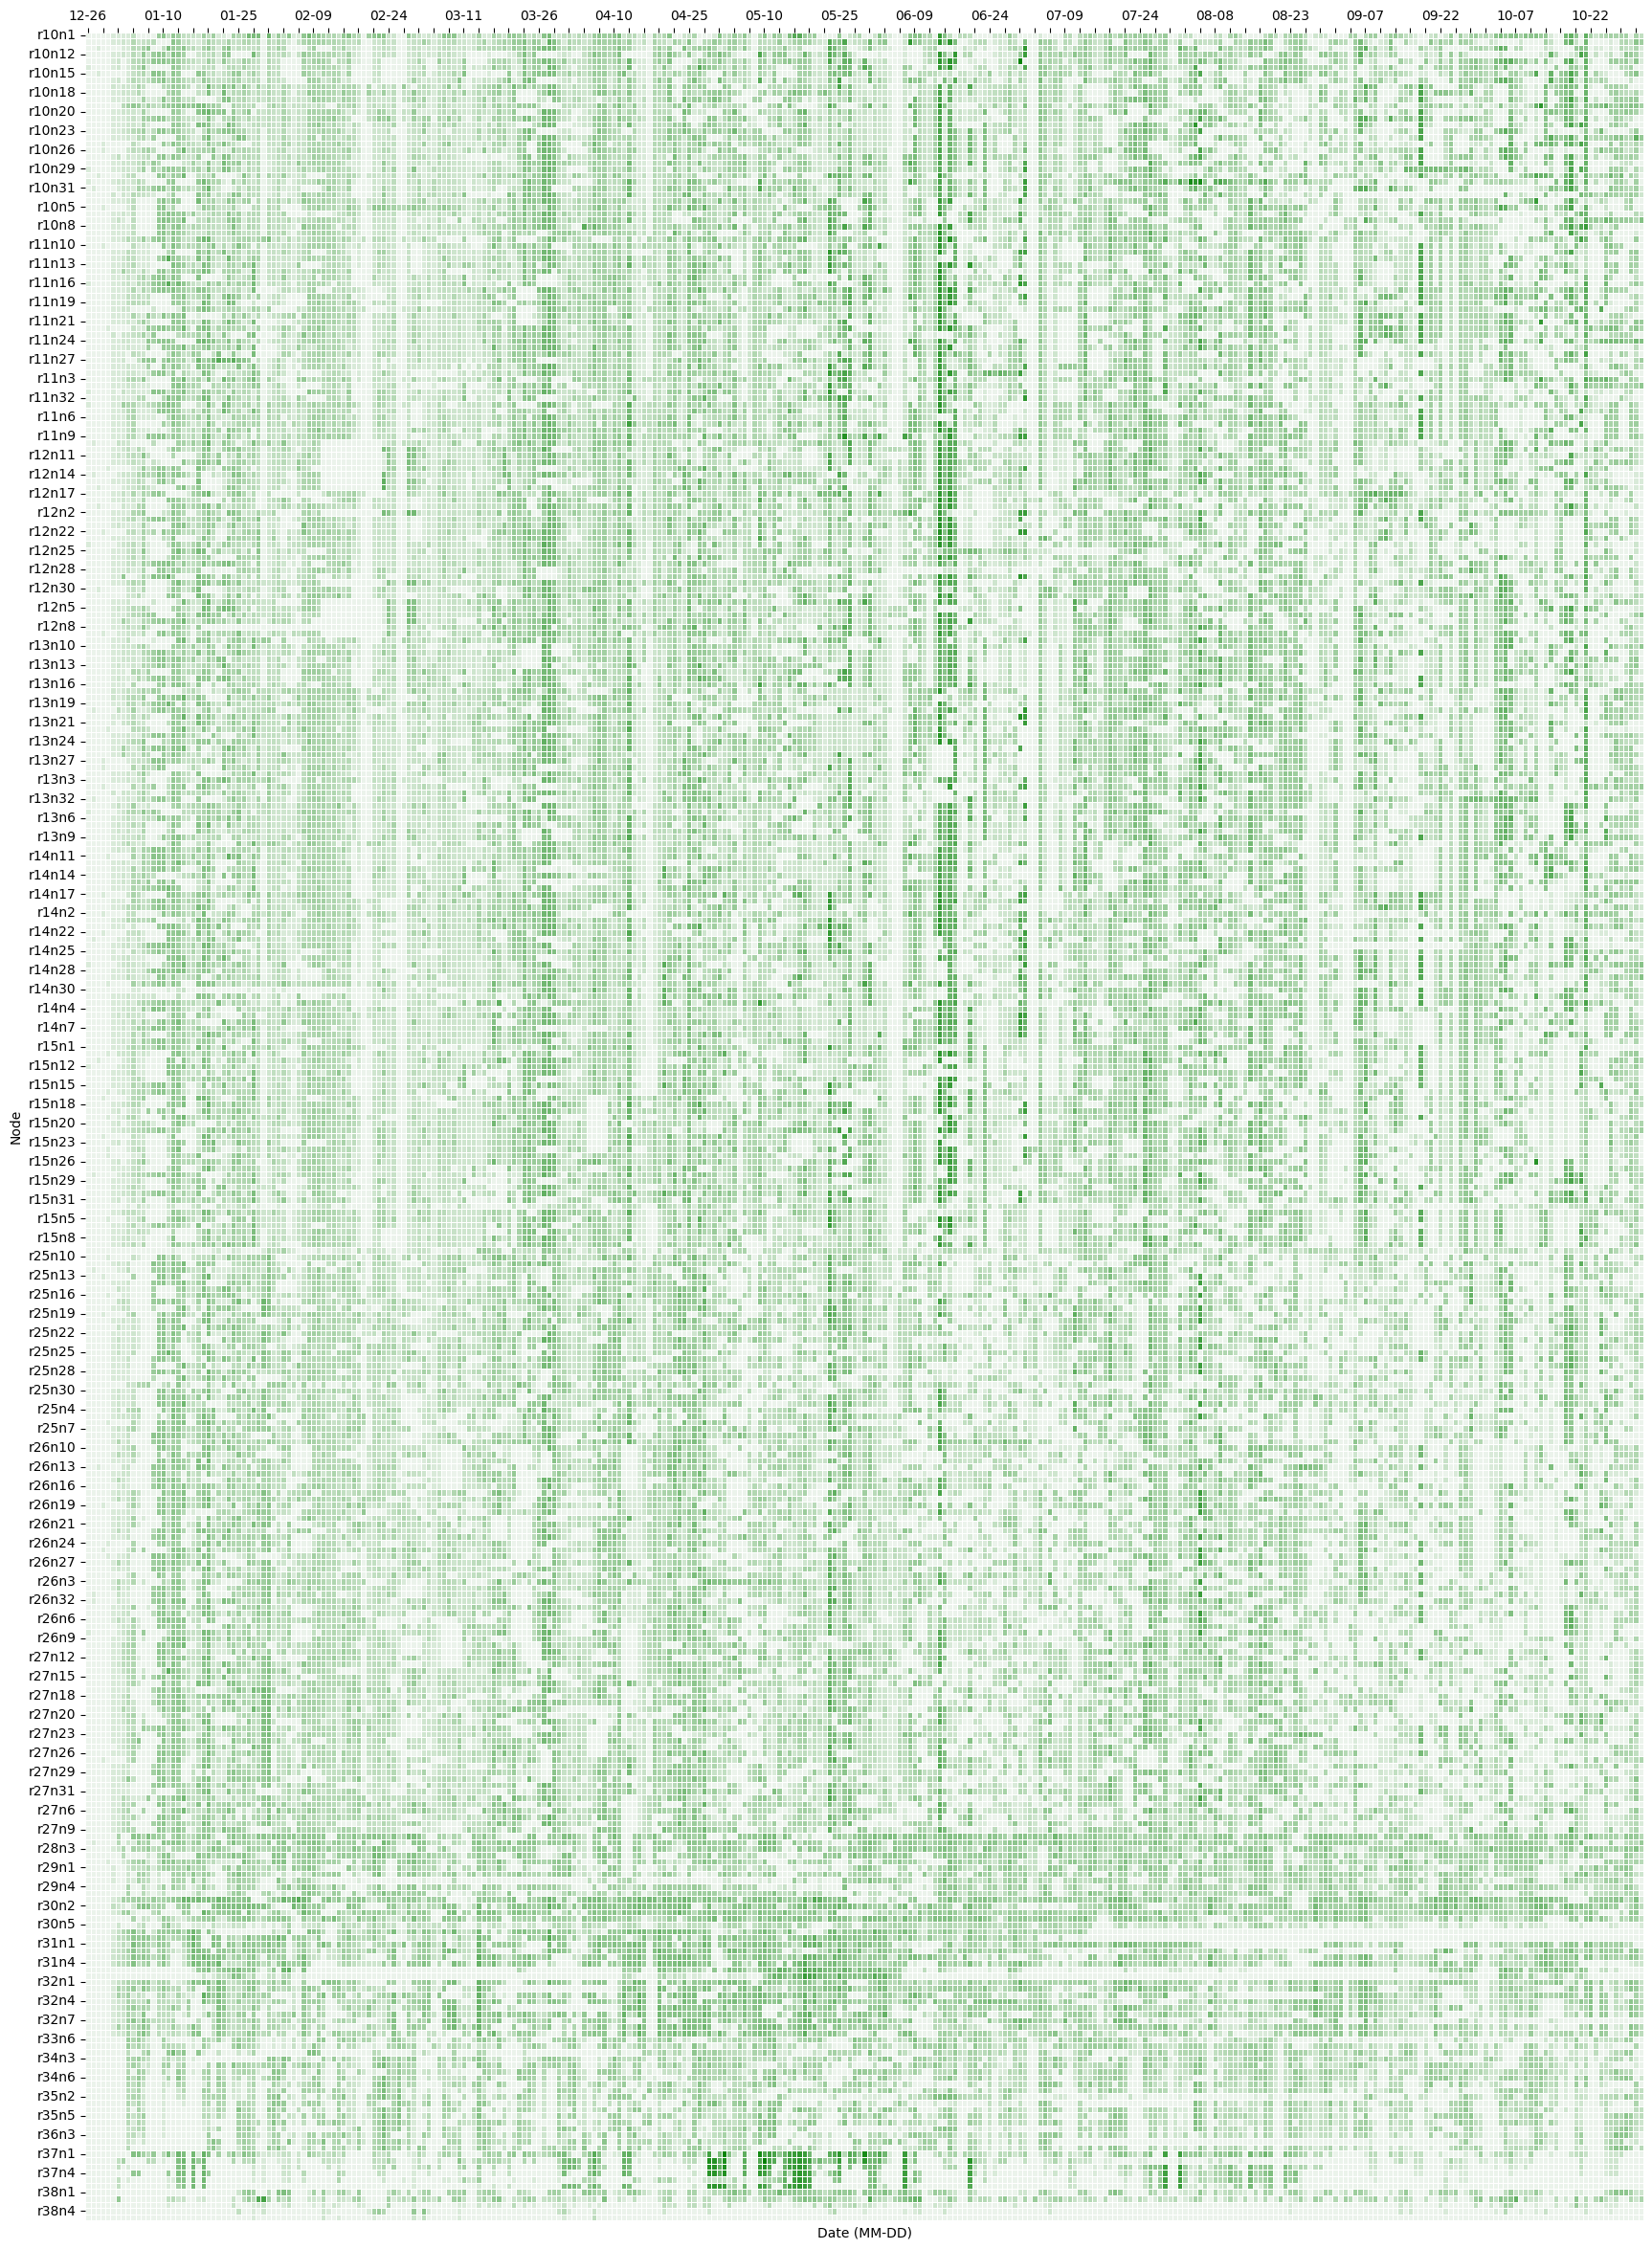

In [12]:

pivot_df = agg_df.pivot('node', 'day', 'count').fillna(0)

pivot_log = np.log1p(pivot_df)  

cmap = sns.light_palette("green", as_cmap=True)

plt.figure(figsize=(21, 29.7))

ax = sns.heatmap(pivot_log, cmap=cmap, linewidths=.5, cbar=False)

n = 5
labels = [label.get_text()[-5:] for label in ax.get_xticklabels()]  
sparse_labels = ['' if (i % n) != 0 else label for i, label in enumerate(labels)]
ax.set_xticklabels(sparse_labels)

ax.xaxis.tick_top()

plt.xlabel('Date (MM-DD)', position=(1,0))
plt.ylabel('Node')

plt.savefig('heatmap_log_transposed.pdf', bbox_inches='tight')

plt.show()








/tmp/ipykernel_613014/3674447852.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = agg_df.pivot('node', 'day', 'count').fillna(0)


/tmp/ipykernel_613014/3674447852.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


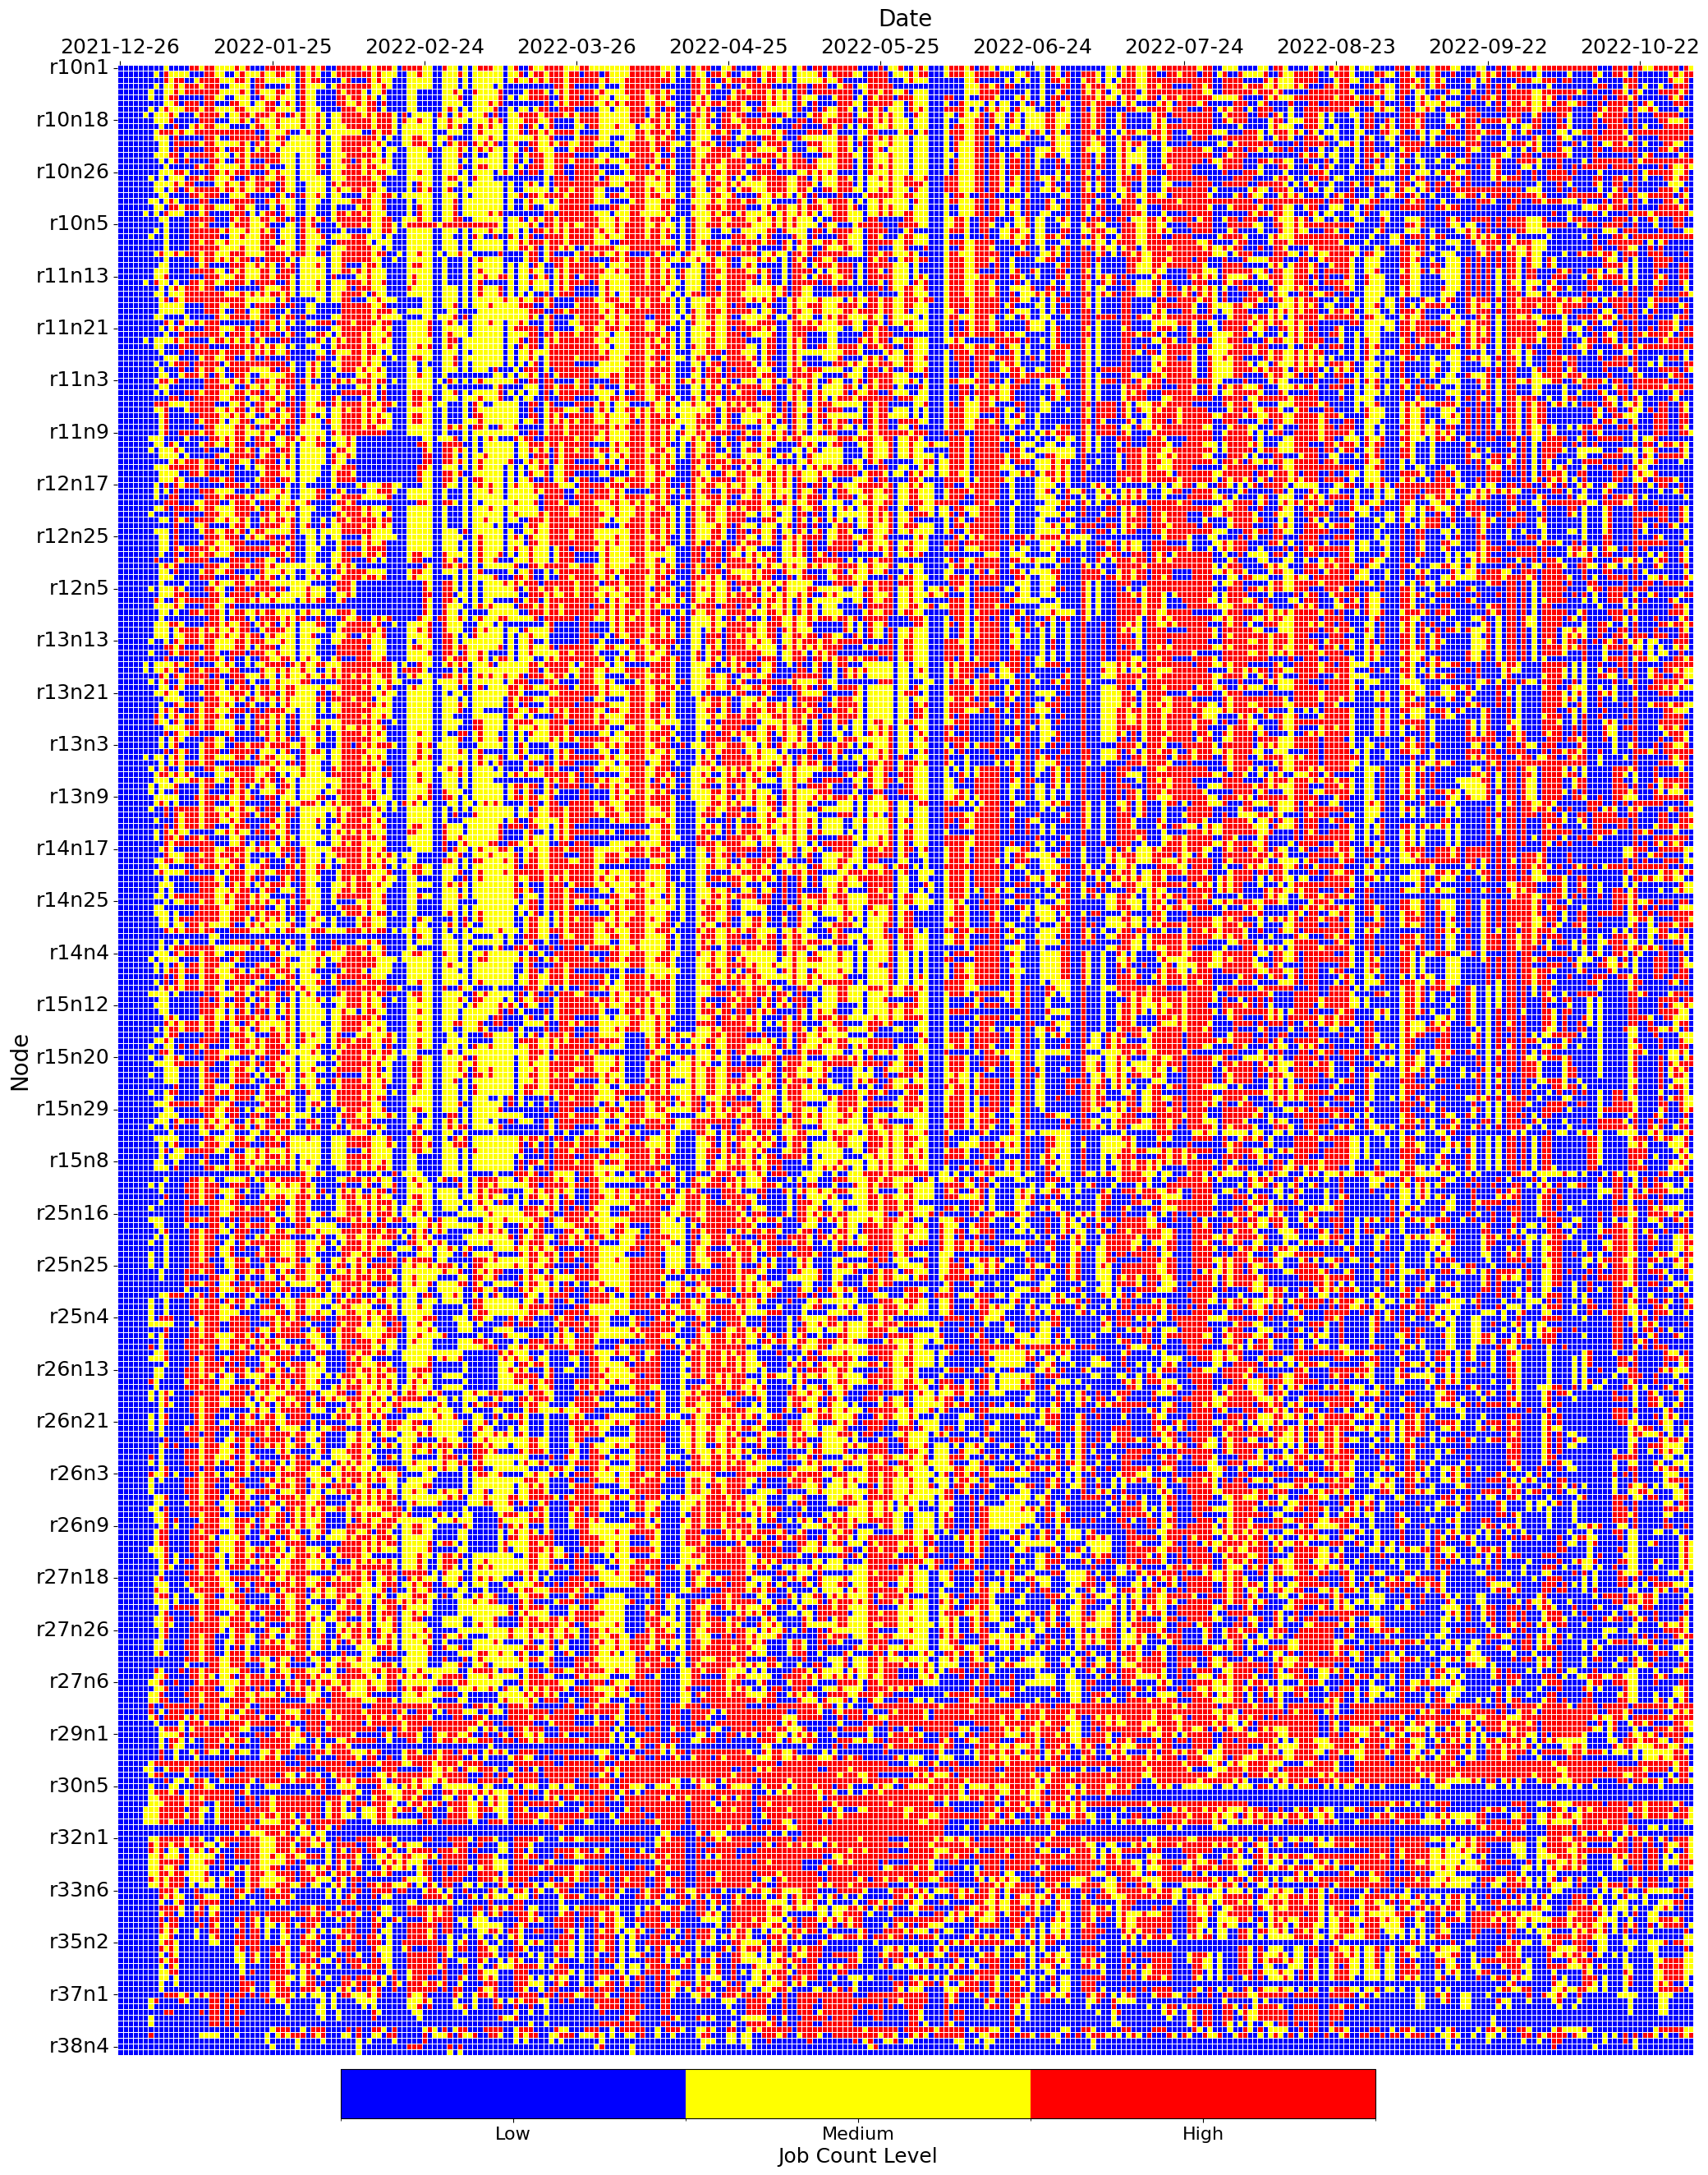

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm


cmap = ListedColormap(['blue', 'yellow', 'red'])
bounds = [0, 1, 2, 303]  
norm = BoundaryNorm(bounds, cmap.N)

pivot_df = agg_df.pivot('node', 'day', 'count').fillna(0)
pivot_log = np.log1p(pivot_df)

fig, ax = plt.subplots(figsize=(21, 29.7))

sns.heatmap(pivot_log, cmap=cmap, norm=norm, cbar=False, linewidths=.5, ax=ax)

ax.xaxis.tick_top()

n_x, n_y = 10, 3
ax.set_xticks(ax.get_xticks()[::n_x])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticks(ax.get_yticks()[::n_y])
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

ax.set_xlabel('Date', fontsize=20, labelpad=10)
ax.xaxis.set_label_position('top')  
ax.set_ylabel('Node', fontsize=20)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  
ticks = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds) - 1)]  
cbar = plt.colorbar(ax.collections[0], cax=cbar_ax, cmap=cmap, norm=norm, boundaries=bounds, ticks=ticks, orientation='horizontal')
cbar.set_label('Job Count Level', fontsize=18)
cbar.ax.set_xticklabels(['Low', 'Medium', 'High'], fontsize=16)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plt.savefig('heatmap_log_transposed.pdf', bbox_inches='tight')

plt.show()


In [14]:
pivot_df.describe()

day,2021-12-26,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2022-10-23,2022-10-24,2022-10-25,2022-10-26,2022-10-27,2022-10-28,2022-10-29,2022-10-30,2022-10-31,2022-11-01
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,...,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.031977,0.031977,0.023256,0.055233,0.049419,0.715116,1.424419,1.781977,3.319767,5.505814,...,3.273256,10.020349,14.566860,8.043605,7.822674,5.337209,5.014535,8.404070,8.357558,2.549419
std,0.176194,0.176194,0.150934,0.228766,0.217056,0.545540,2.284461,2.905031,3.776877,7.934864,...,7.385731,31.320727,31.781619,12.791937,10.833242,9.653605,8.151075,9.271863,14.713297,6.699541
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.750000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,1.000000,3.000000,2.000000,1.000000,2.000000,5.000000,6.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,4.000000,8.000000,...,3.000000,5.000000,18.250000,12.000000,14.000000,8.000000,7.000000,15.000000,10.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,28.000000,31.000000,28.000000,63.000000,...,61.000000,303.000000,276.000000,104.000000,68.000000,81.000000,39.000000,52.000000,208.000000,50.000000


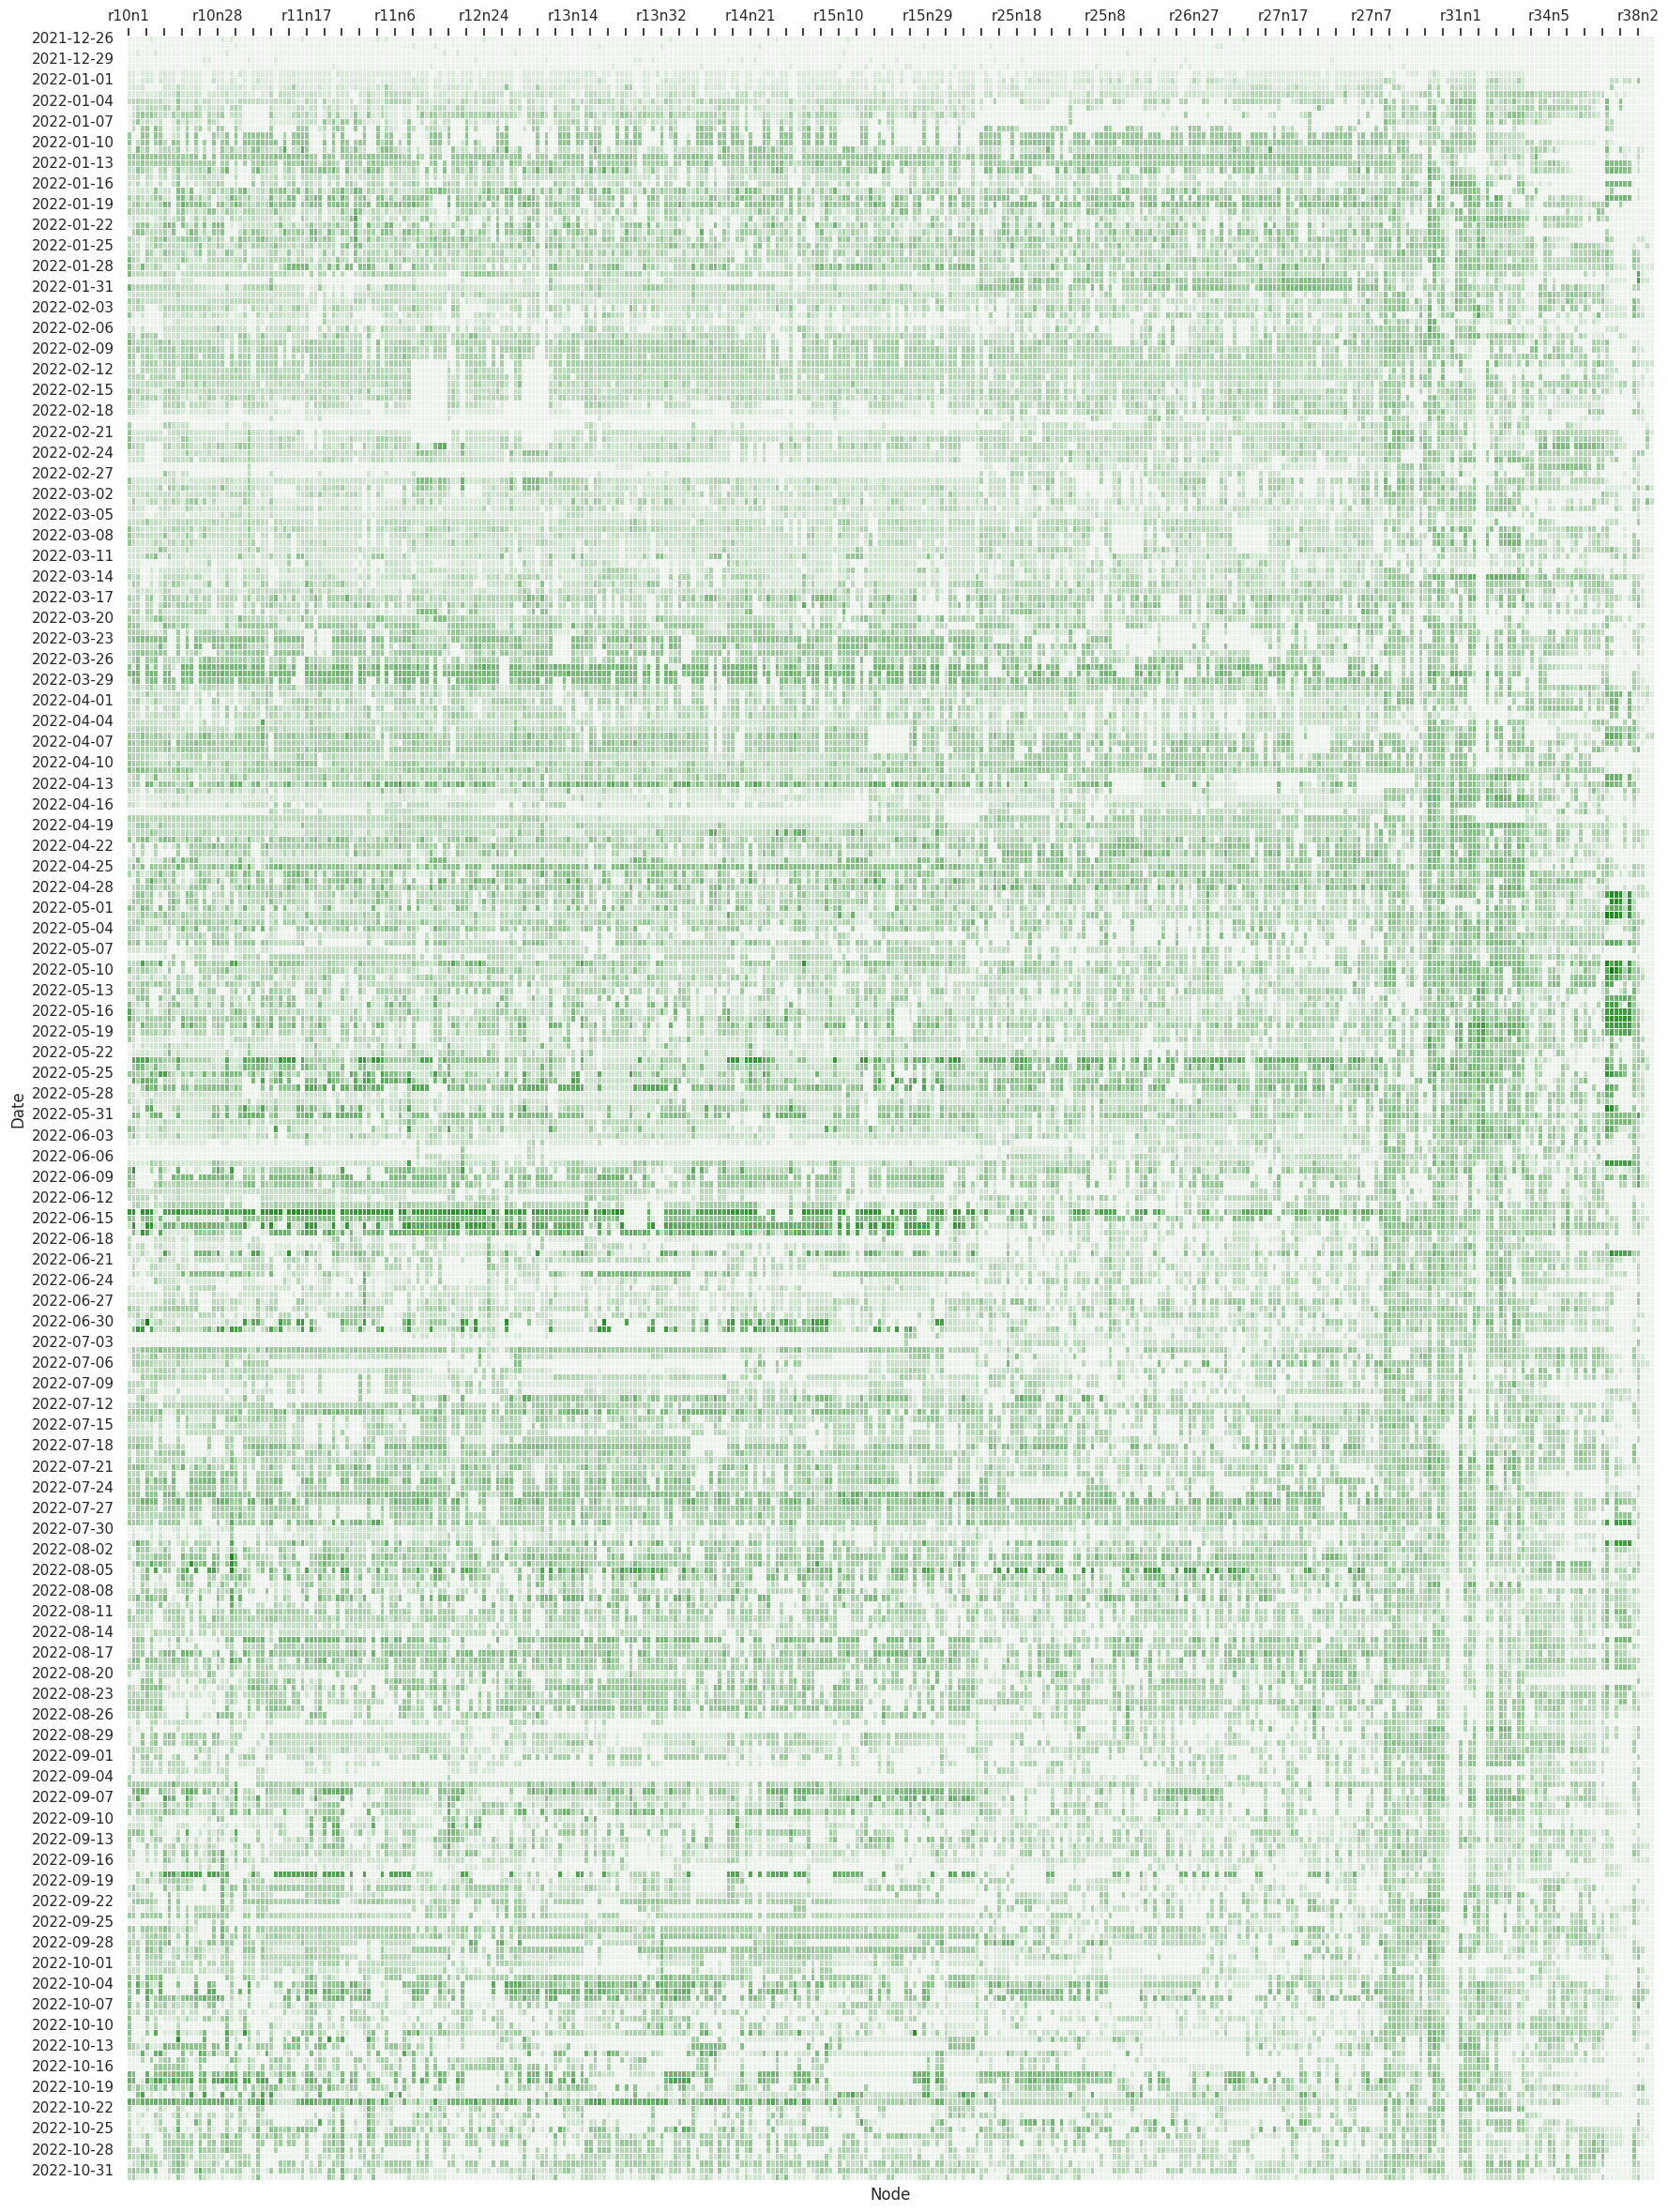

In [21]:
pivot_log = np.log1p(pivot_df)  

cmap = sns.light_palette("green", as_cmap=True)

plt.figure(figsize=(21, 29.7))

ax = sns.heatmap(pivot_log, cmap=cmap, linewidths=.5,cbar=False)

ax.xaxis.tick_top()

n = 5
labels = [label.get_text() for label in ax.get_xticklabels()]
sparse_labels = ['' if (i % n) != 0 else label for i, label in enumerate(labels)]
ax.set_xticklabels(sparse_labels)

plt.xlabel('Node', position=(1,0))
plt.ylabel('Date')

plt.savefig('heatmap_log.pdf', bbox_inches='tight')

plt.show()

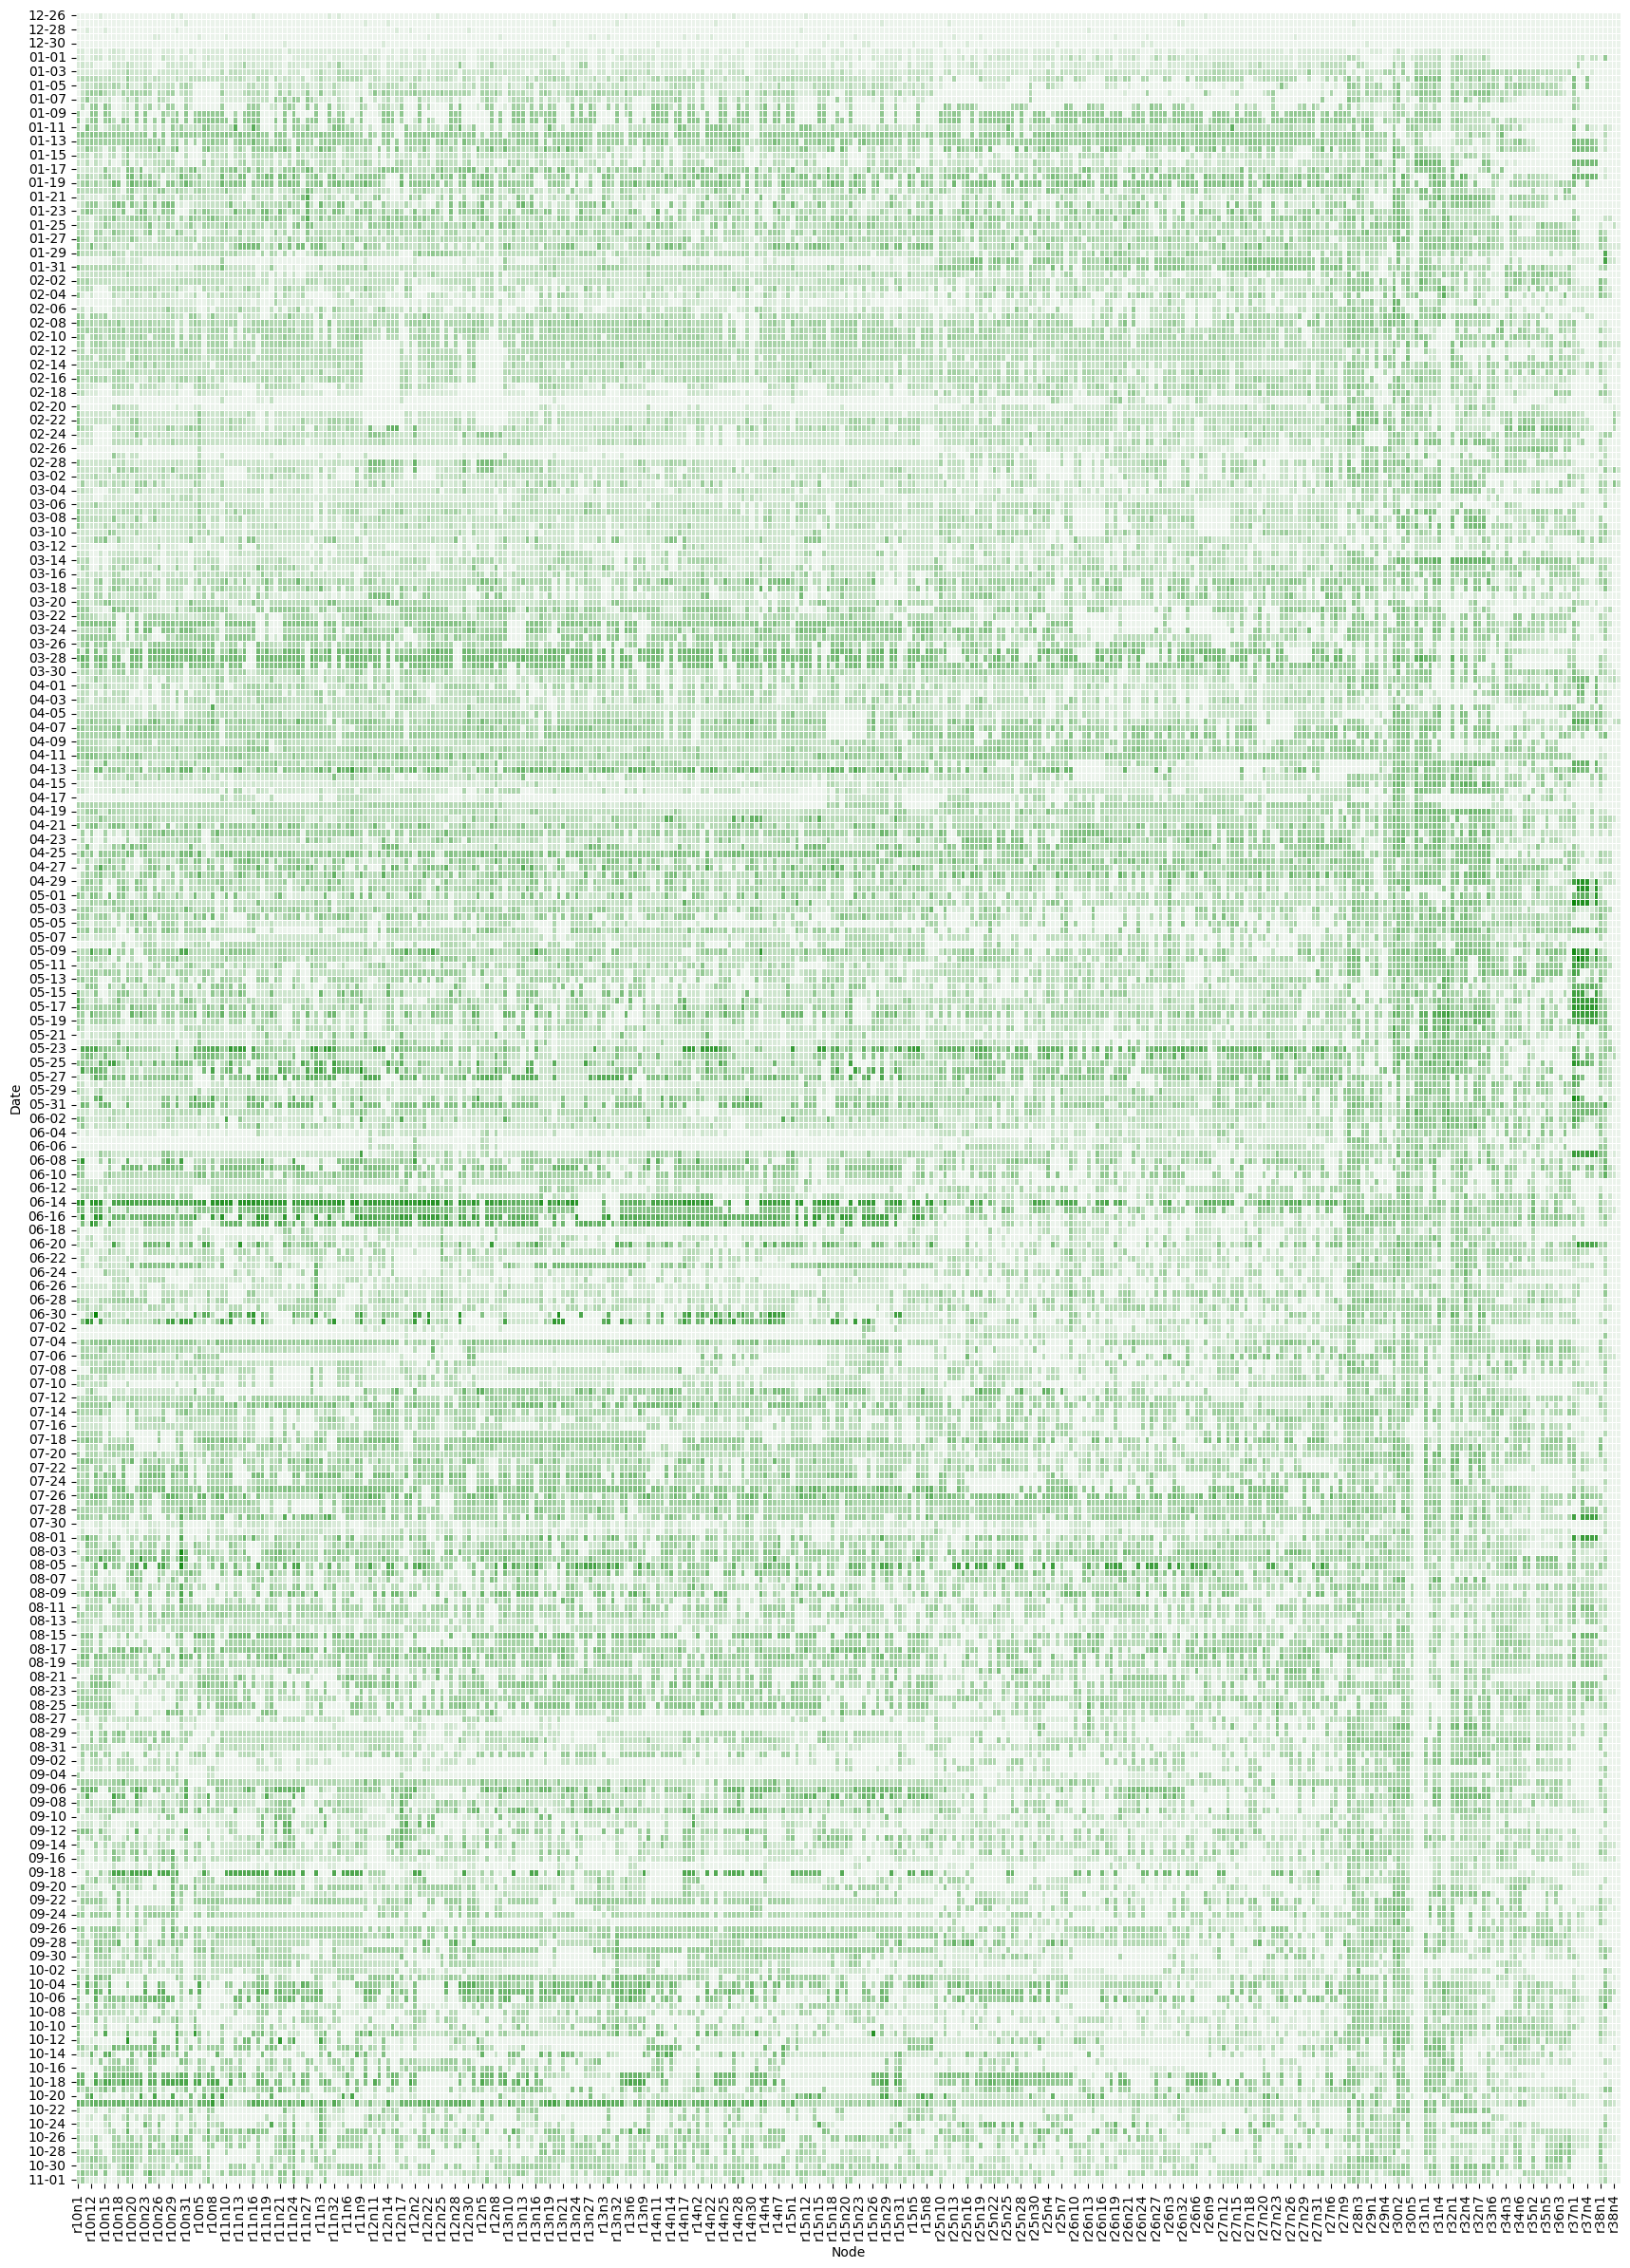

In [20]:
pivot_log = np.log1p(pivot_df)  

cmap = sns.light_palette("green", as_cmap=True)

plt.figure(figsize=(21, 29.7))

sns.heatmap(pivot_log, cmap=cmap, linewidths=.5,cbar=False)

plt.xlabel('Node')
plt.ylabel('Date')

plt.savefig('heatmap_log.pdf', bbox_inches='tight')

plt.show()

In [25]:
overall_summary = pivot_df.describe().loc[['mean', 'min', '25%', '50%', '75%', 'max']]
print("\n总体任务数量统计:\n", overall_summary)

most_jobs_nodes = pivot_df.sum().nlargest(5).index

least_jobs_nodes = pivot_df.sum().nsmallest(5).index

print("\n任务数量最多的5个节点统计:\n", pivot_df[most_jobs_nodes].describe().transpose())
print("\n任务数量最少的5个节点统计:\n", pivot_df[least_jobs_nodes].describe().transpose())



总体任务数量统计:
 node        r10n1      r10n10       r10n11       r10n12       r10n13  \
mean    19.041801    25.81672    17.122186    26.382637    46.855305   
min      0.000000     0.00000     0.000000     0.000000     0.000000   
25%      1.000000     1.00000     0.000000     0.000000     1.000000   
50%      4.000000     4.00000     4.000000     2.000000     5.000000   
75%     16.500000    12.00000    11.000000    12.000000    16.500000   
max   1358.000000  1532.00000  1336.000000  1540.000000  5764.000000   

node       r10n14      r10n15      r10n16      r10n17      r10n18  ...  \
mean    23.282958   13.424437   16.237942   18.765273   13.623794  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
25%      0.000000    0.000000    0.000000    1.000000    1.000000  ...   
50%      3.000000    3.000000    3.000000    4.000000    4.000000  ...   
75%     12.000000   11.000000   11.000000   12.500000   13.000000  ...   
max   1450.000000  383.000000  528.0000